In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.eval import calculate_rouge, calculate_f1_score

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("data/squad/test.csv")

scores = np.fromfile("results/checkpoint-26280_squad_scores")
with open("results/checkpoint-26280_squad_sentences") as file:
    texts = [line.rstrip() for line in file]

In [3]:
rougels, f1s = list[float](), list[float]()
for pred, label in zip(texts, df["target"]):
    rouge = calculate_rouge(predictions=[pred], references=[[label]])["rougeL"]
    f1 = calculate_f1_score(prediction=pred, ground_truth=label)
    rougels.append(rouge)
    f1s.append(f1)

In [4]:
df_score = pd.DataFrame(
    {
        "rougel": rougels,
        "f1": f1s,
        "cert": scores,
    }
)

In [5]:
np.corrcoef(df_score["rougel"], df_score["cert"])

array([[1.        , 0.38398584],
       [0.38398584, 1.        ]])

In [6]:
np.corrcoef(df_score["f1"], df_score["cert"])

array([[1.        , 0.37842908],
       [0.37842908, 1.        ]])

Text(0, 0.5, 'RougeLSum')

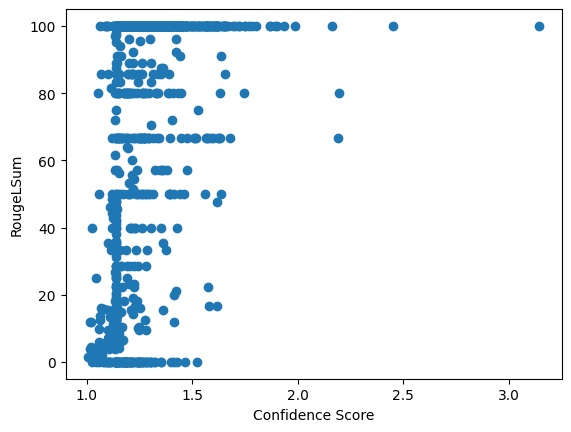

In [7]:
plt.scatter(y=df_score["rougel"], x=df_score["cert"])
plt.xlabel("Confidence Score")
plt.ylabel("RougeLSum")

Text(0, 0.5, 'F1')

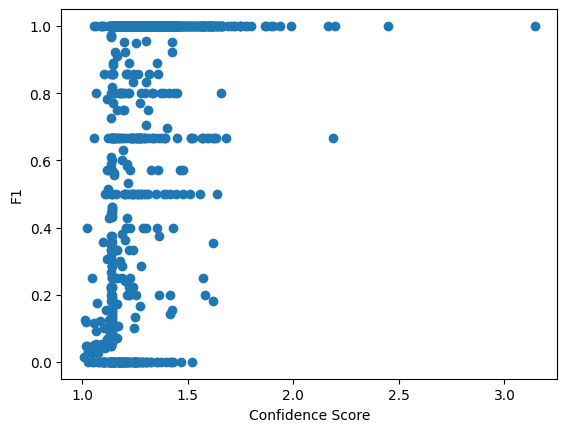

In [9]:
plt.scatter(y=df_score["f1"], x=df_score["cert"])
plt.xlabel("Confidence Score")
plt.ylabel("F1")